In [ ]:
!pip install annoy
!pip install hnswlib
!pip install faiss


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from annoy import AnnoyIndex
import hnswlib
import faiss  

In [ ]:
import numpy as np
import random
import time
import pickle

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.style.use('ggplot')
import seaborn as sns

In [ ]:
f = 'image_ids_and_rotation_batch_aq.npz'
#f = 'a2.npz'
with np.load(f) as data:
    a = data['arr_0']
    ids = data['ids.npy']

print(a.shape)
print(ids.shape)
print(ids)
print(a)


(9194, 512)
(9194,)
['b474da30beb1f742' '0a3467cc6e2cff0d' '8d18815efdfd39a5' ...
 '35a10e92c1ecbc83' '0cc505fe22a56634' '803dfca00f927cb7']
[[3.62802148e-01 1.18658885e-04 1.07221857e-01 ... 4.45766956e-01
  1.13365045e-02 4.41948295e-01]
 [1.20701814e+00 1.85349393e+00 2.07393360e+00 ... 1.06401730e+00
  1.26606858e+00 1.26022601e+00]
 [5.39373681e-02 7.31724560e-01 2.62398869e-01 ... 7.16800615e-02
  9.09169242e-02 1.02727044e+00]
 ...
 [3.11794758e-01 2.32343107e-01 5.89570582e-01 ... 1.66449225e+00
  1.20455468e+00 4.44580168e-01]
 [9.42772329e-01 2.05837011e+00 1.38681746e+00 ... 1.55521274e-01
  2.39644378e-01 1.22861171e+00]
 [1.24962114e-01 1.06985128e+00 1.04345024e+00 ... 1.10118783e+00
  1.97646880e+00 5.63046992e-01]]


In [ ]:
len(a[1])

512

In [ ]:
f = 512
dim = f
num_elements = 9194

t = AnnoyIndex(f, 'angular')

p = hnswlib.Index(space = 'l2', dim = dim)
p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

for i in range(num_elements):
    v = a[i]
    t.add_item(i, v)
    p.add_items(v, i)

t.build(10) # 10 trees
t.save('a2.ann')

p.set_ef(50)

In [ ]:
NN = [10,100,200,500,1000]
tt1 = []
tt2 = []
tt3 = []

u = AnnoyIndex(f, 'angular')
u.load('a2.ann') 

for N in NN:
  
  t1 = time.perf_counter() 
  for i in range(N):
    n = random.randint(0, 9000)
    nns = u.get_nns_by_item(n, 100)
  t2 = time.perf_counter() 
  dt = t2-t1
  tt1 += [dt]
  print(N, dt)

  t1 = time.perf_counter() 
  for i in range(N):
    n = random.randint(0, 900)
    data = [random.gauss(0, 1) for z in range(f)]
    labels, distances = p.knn_query(data, k=N)
  t2 = time.perf_counter() 
  dt = t2-t1
  tt2 += [dt]
  print(N, dt)


10 0.005768576000036774
10 0.008374718999903052
100 0.027623597999991034
100 0.06353306599999087
200 0.04887946600001669
200 0.15862158899994938
500 0.12399290900009419
500 0.6862332819999892
1000 0.371727604000057
1000 3.273711404999972


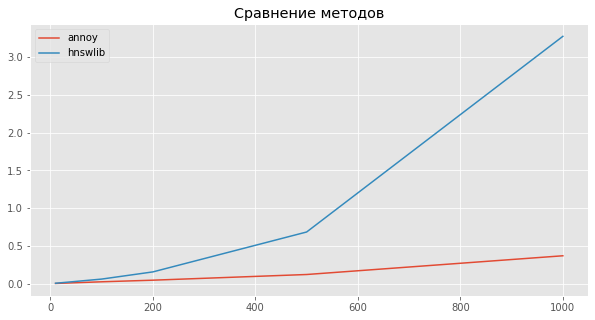

In [ ]:
plt.plot(NN, tt1, label='annoy');
plt.plot(NN, tt2, label='hnswlib');
#plt.plot(NN, tt3, label='faiss ivf');
plt.legend();
plt.title('Сравнение методов');

------------

In [ ]:
f = 40
num_elements = 10000

t = AnnoyIndex(f, 'angular')

dim = f
p = hnswlib.Index(space = 'l2', dim = dim)
p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

for i in range(num_elements):
    v = [random.gauss(0, 1) for z in range(f)]
    t.add_item(i, v)
    p.add_items(v, i)

t.build(10) # 10 trees
t.save('test.ann')

p.set_ef(50)

In [ ]:
nb = num_elements
d = f

xb = np.random.random((nb, d)).astype('float32')
index = faiss.IndexFlatL2(d) 
#index = faiss.index_factory(d,"PCA32,IVF100,PQ8 ")
index.add(xb)

In [ ]:
NN = [10,100,200,500,1000]
tt1 = []
tt2 = []
tt3 = []

u = AnnoyIndex(f, 'angular')
u.load('test.ann') 

for N in NN:
  
  t1 = time.perf_counter() 
  for i in range(N):
    n = random.randint(0, 900)
    nns = u.get_nns_by_item(n, 100)
  t2 = time.perf_counter() 
  dt = t2-t1
  tt1 += [dt]
  print(N, dt)

  t1 = time.perf_counter() 
  for i in range(N):
    n = random.randint(0, 900)
    data = [random.gauss(0, 1) for z in range(f)]
    labels, distances = p.knn_query(data, k=N)
  t2 = time.perf_counter() 
  dt = t2-t1
  tt2 += [dt]
  print(N, dt)


  t1 = time.perf_counter() 
  for i in range(N):
    n = random.randint(0, 900)
    data = [random.gauss(0, 1) for z in range(f)]

    D, I = index.search(xb[:5], N) 
    
  t2 = time.perf_counter() 
  dt = t2-t1
  tt3 += [dt]
  print(N, dt)



10 0.0025117769999951634
10 0.0024077450000277167
10 0.029458880999982284
100 0.04505208600005517
100 0.09986277899997731
100 0.22035491099995852
200 0.03912142000001495
200 0.08796032199995807
200 0.673409220999929
500 0.19124938599998131
500 0.60642107700005
500 0.7995329400000628
1000 0.1713678380000374
1000 0.8535245629999508
1000 2.150304492000032


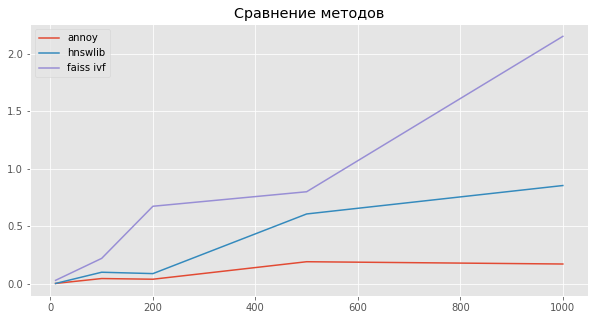

In [ ]:
plt.plot(NN, tt1, label='annoy');
plt.plot(NN, tt2, label='hnswlib');
plt.plot(NN, tt3, label='faiss ivf');
plt.legend();
plt.title('Сравнение методов');